In [1]:
import os, sys
# import numpy as np
from collections import OrderedDict

from tools import *
import numpy as np
import os
import tensorflow as tf
import tensorflow_core.python.keras.callbacks
import keras

from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import GlobalMaxPooling1D, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Conv1D, MaxPooling1D
from keras.initializers import he_normal
from keras import optimizers
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.layers.normalization import BatchNormalization
# from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.utils.data_utils import get_file
from keras import backend as K

import itertools
# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.metrics import *

os.chdir(sys.path[0])

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 使用cpu

In [49]:
config = {
    'gen_name': 'Streptococcus pyogenes',
    'p_path': '/root/zjj/dataset/pathogens_v1',
    'k_length': 100,
    'interval': 1000  # 划分k-mer时，两个相邻的k-mer的距离
}
from config import Config
version = 'v6'
# gen_name = Config.config[version]['gen_name']
gen_name = Config.config_v1[version]['gen_name']
data_path = os.path.join(config['p_path'], 'data')

k_len = config['k_length']
import json
with open('./parent_information/parent_v1.json', 'r', encoding='utf-8') as f:
    parent_list = json.load(f)

num_classes = len(parent_list[-1])
epochs = 2
batch_size = 256

tr_rate = 0.95
val_rate = 0.2

In [53]:
def load_data_v1():
    idx = 0
    interval = Config.config_v1[version]['interval']
    k_length = Config.config_v1[version]['k-mer']
    interval = config['interval']
    k_length = config['k_length']
    code_list = OrderedDict()
    for curname in gen_name:
        load_name = curname + '_k' + str(k_length) \
                    + '_i' + str(interval) + '.npy'
        load_path = Config.config_v1[version]['data_path']

        load_path = '/root/dgh_v1/zjj/dataset/pathogens_v1/test'
        

        load_path = os.path.join(load_path, load_name)
        code = np.load(load_path)
        code = shuf_data(code)  # 随机打乱
        code_tr = code[:int(code.shape[0] * tr_rate)]  # 训练
        code_val = code[int(code.shape[0] * tr_rate):]  # 验证
        if idx == 0:
            # X_all = code
            X_tr = code_tr
            X_val = code_val
            Y_tr = np.repeat(idx, X_tr.shape[0])
            Y_val = np.repeat(idx, X_val.shape[0])
        else:
            X_tr = np.concatenate((X_tr, code_tr))
            X_val = np.concatenate((X_val, code_val))
            Y_tr = np.concatenate((Y_tr, np.repeat(idx, code_tr.shape[0])))
            Y_val = np.concatenate((Y_val, np.repeat(idx, code_val.shape[0])))

        len = code.shape[0]
        # code_list[curname] = code
        idx = idx + 1
        del code
        del code_tr
        del code_val
        print(idx)
    return X_tr, Y_tr, X_val, Y_val

In [54]:
X_tr, Y_tr, X_val, Y_val = load_data_v1()

Y_tr = keras.utils.to_categorical(Y_tr, num_classes)
Y_val = keras.utils.to_categorical(Y_val, num_classes)

print('hello')

index = list(range(0, X_val.shape[0]))
np.random.shuffle(index)
X_val = X_val[index]
Y_val = Y_val[index]

parent = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0,
    5: 1, 6: 1, 7: 1, 8: 1, 9: 1
}
# parent_list = [{"0": -1, "1": -1, "2": -1}, {"0": 0, "1": 1, "2": 0, "3": 0, "4": 1, "5": 0, "6": 0, "7": 0, "8": 2, "9": 1}]
import json
with open('./parent_information/parent_v1.json', 'r', encoding='utf-8') as f:
    parent_list = json.load(f)
parent = parent_list[1]

n1 = len(parent_list[0])
n2 = len(parent_list[1])

p_num = len(parent_list[0])
yp_tr = np.zeros((Y_tr.shape[0], p_num)).astype("float32")
yp_val = np.zeros((Y_val.shape[0], p_num)).astype("float32")
for i in range(yp_tr.shape[0]):
    yp_tr[i][parent[str(np.argmax(Y_tr[i]))]] = 1.0
for i in range(yp_val.shape[0]):
    yp_val[i][parent[str(np.argmax(Y_val[i]))]] = 1.0

print(X_tr.shape)
print(X_val.shape)

1
2
3
4
5
6
7
8
9
10
11
12
hello
(39464, 100, 4)
(2084, 100, 4)


In [7]:
from model import *
sgd = optimizers.SGD(lr=0.003, momentum=0.9, nesterov=True)
alpha = K.variable(value=0.99, dtype="float32", name="alpha")  # A1 in paper
#alpha  = tf.keras.backend.variable(0.99)
beta = K.variable(value=0.01, dtype="float32", name="beta")  # A2 in paper
#beta = tf.keras.backend.variable(0.01)
inputs = Input(shape=(None, 4))  # The input shape doesn’t include the number of samples.
# 在使用基于tensorflow的keras中，cov1d的input_shape是二维的

# sgd = optimizers.SGD(lr=0.003, momentum=0.9, nesterov=True)
#
inputs = Input((config['k_length'], 4))
model = get_BranchModel7(inputs)
print(model.summary())
model.load_weights('./weights/config_v1/BranchModel7_v6.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              loss_weights=[alpha, beta],
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/root/dgh_v1/zjj/Code/Z/model.py:703: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="medium_dynamic", inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  model = Model(input=inputs, output=[c2_pred, fine_pred], name='medium_dynamic')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 4)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 91, 64)       2624        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 91, 64)       256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 82, 128)      82048       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [60]:
def predict_classes1(model, X_val):
    pred = model.predict(X_val)
    pred = np.argmax(pred, axis=-1)
    return pred

def predict_classes2(model, X_val):
    pred = model.predict(X_val)
    pred1 = np.argmax(pred[0], axis=-1)
    pred2 = np.argmax(pred[1], axis=-1)
    return pred1, pred2

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.jet):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes)
    phylum_name=['Proteobacteria','Firmicutes','Actinobacteria','Tenericutes','Chlamydiae']
    species_name=['H.influenzae','S.pneumoniae','S.maltophilia','L.pneumophila','S.aureus','P.aeruginosa','K.pneumoniae','A.baumannii','M.tuberculosis','S.pyogenes','M.pneumoniae','C.pneumoniae']
    # plt.yticks(tick_marks, classes)
    plt.yticks(tick_marks, phylum_name)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def npsave(conf_mat, ):
    np.save('./conf_mat/mat', conf_mat)

# 显示混淆矩阵
def plot_confuse(model, x_val, y_val):
    #predictions = predict_classes1(model, x_val)
    pred1, pred2 = predict_classes2(model, x_val)
    truelabel = y_val.argmax(axis=-1)   # 将one-hot转化为label
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=pred1)
    print(np.max(truelabel)+1)
    #npsave()
    
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=pred1)
    plt.figure()
    plot_confusion_matrix(conf_mat, range(np.max(truelabel)+1), title='coarse label')
    plt.savefig(fname='./conf_mat/figure1.svg', format='svg')
    return conf_mat

5


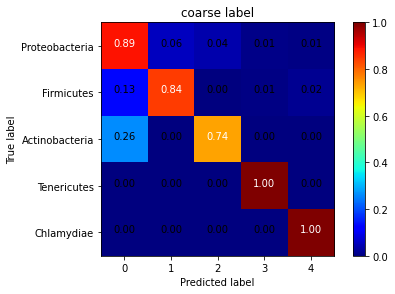

In [61]:
conf_mat = plot_confuse(model, X_val, yp_val)


5


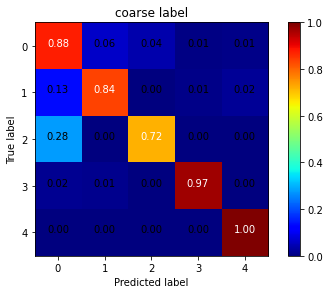

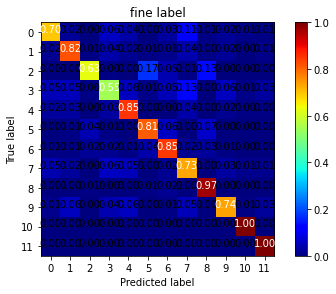

In [34]:
def plot_confuse(model, x_val, yp_val, y_val):
    #predictions = predict_classes1(model, x_val)
    pred1, pred2 = predict_classes2(model, x_val)
    truelabel = yp_val.argmax(axis=-1)   # 将one-hot转化为label
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=pred1)
    print(np.max(truelabel)+1)
    #npsave()
    plt.figure()
    plot_confusion_matrix(conf_mat, range(np.max(truelabel)+1), title='coarse label')
    plt.savefig(fname="./conf_mat/figure1.svg",format="svg")
    plt.show()
    truelabel = y_val.argmax(axis=-1)   # 将one-hot转化为label
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=pred2)
    
    plt.figure()
    plot_confusion_matrix(conf_mat, range(np.max(truelabel)+1), title='fine label')
    plt.savefig(fname='./conf_mat/figure2.svg', format='svg')
    plt.show()
    return conf_mat
conf_mat = plot_confuse(model, X_val, yp_val, Y_val)

In [1]:
# plt.imshow('./conf_mat/figure1.svg')